In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 5

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1125 (4.39 KB)
Trainable params: 1125 (4.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/29 [>.............................] - ETA: 7s - loss: 1.9280 - accuracy: 0.1016
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
29/29 [==============================] - 0s 6ms/step - loss: 1.7901 - accuracy: 0.1275 - val_loss: 1.6265 - val_accuracy: 0.2425
Epoch 2/1000
 1/29 [>.............................] - ETA: 0s - loss: 1.6009 - accuracy: 0.2734
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
29/29 [==============================] - 0s 2ms/step - loss: 1.6005 - accuracy: 0.2799 - val_loss: 1.5146 - val_accuracy: 0.3816
Epoch 3/1000
 1/29 [>.............................] - ETA: 0s - loss: 1.5448 - accuracy: 0.3203
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
29/29 [==============================] - 0s 2ms/step - loss: 1.4939 - accuracy: 0.3530 - val_loss: 1.4226 - val_accuracy: 0.3709
Epoch 4/1000
 1/29 [>.............................] - ETA: 0s - loss: 1.4921 - accuracy: 0.328

In [13]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 [==============================] - 0s 766us/step - loss: 0.2206 - accuracy: 0.9520


In [14]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 50ms/step
[9.6080863e-01 3.3190347e-02 3.3795505e-03 9.5352380e-06 2.6119389e-03]
0


# Confusion matrix

38/38 [==============================] - 0s 476us/step


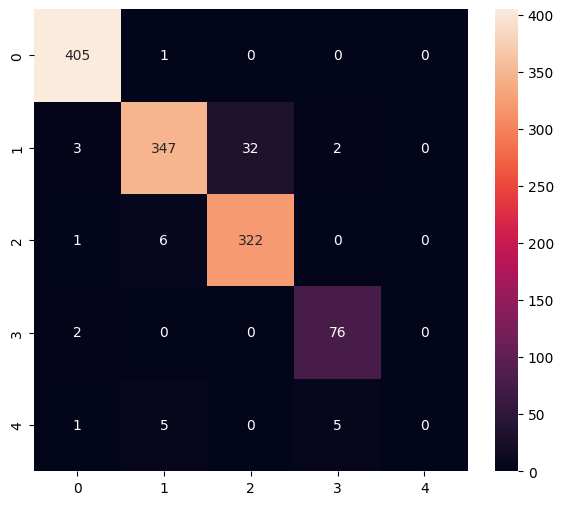

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       406
           1       0.97      0.90      0.93       384
           2       0.91      0.98      0.94       329
           3       0.92      0.97      0.94        78
           4       0.00      0.00      0.00        11

    accuracy                           0.95      1208
   macro avg       0.75      0.77      0.76      1208
weighted avg       0.94      0.95      0.95      1208



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [17]:
# Save as a model dedicated to inference
model.save(model_save_path)

In [18]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/b8/vkvzb0nd3mq4q15ss9ph1pv80000gp/T/tmpk1ma8jf7/assets


INFO:tensorflow:Assets written to: /var/folders/b8/vkvzb0nd3mq4q15ss9ph1pv80000gp/T/tmpk1ma8jf7/assets
2024-02-06 18:50:16.580072: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-06 18:50:16.580086: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-06 18:50:16.580337: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/b8/vkvzb0nd3mq4q15ss9ph1pv80000gp/T/tmpk1ma8jf7
2024-02-06 18:50:16.580961: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-06 18:50:16.580967: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/b8/vkvzb0nd3mq4q15ss9ph1pv80000gp/T/tmpk1ma8jf7
2024-02-06 18:50:16.582100: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-02-06 18:50:16.582642: I tensorflow/cc/saved_model/load

6588

# Inference test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [20]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 90 µs, sys: 58 µs, total: 148 µs
Wall time: 126 µs


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.6080863e-01 3.3190336e-02 3.3795505e-03 9.5352743e-06 2.6119417e-03]
0
